In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models as models
from torchsummary import summary
import time
from tqdm.notebook import tqdm as tqdm
from matplotlib import pyplot as plt

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

In [3]:
# Downloading the dataset
dataset = datasets.CIFAR10(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root='data', train=False, transform=transform, download=True)

100%|██████████| 170498071/170498071 [00:05<00:00, 29075409.33it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
print(len(dataset))
print(len(test_dataset))

50000
10000


In [5]:
num_train = int(len(dataset)*0.8)
num_valid = int(len(dataset))-num_train
train_dataset, valid_dataset = data.random_split(dataset, [num_train, num_valid])
print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

40000
10000
10000


In [6]:
BATCH_SIZE=128
train_iter=data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_iter=data.DataLoader(valid_dataset, batch_size=BATCH_SIZE)
dataloader_dict={'train':train_iter, 'val':val_iter}
test_iter=data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [7]:
batch_iter = iter(train_iter)
inputs, labels = next(batch_iter)
print(inputs.size())
print(labels.size())
print(labels)

torch.Size([128, 3, 32, 32])
torch.Size([128])
tensor([7, 4, 4, 5, 7, 1, 1, 7, 1, 0, 9, 4, 2, 4, 9, 8, 4, 9, 8, 2, 8, 1, 6, 5,
        3, 3, 0, 3, 6, 5, 6, 7, 7, 1, 3, 6, 0, 0, 8, 0, 0, 2, 4, 8, 9, 4, 6, 5,
        9, 1, 8, 1, 3, 4, 7, 2, 7, 6, 0, 4, 7, 1, 8, 2, 1, 5, 8, 5, 9, 9, 2, 8,
        0, 0, 3, 3, 9, 3, 0, 6, 0, 5, 7, 5, 7, 4, 5, 5, 2, 4, 6, 9, 4, 4, 0, 2,
        8, 8, 5, 2, 3, 0, 5, 4, 1, 6, 8, 9, 5, 8, 9, 7, 5, 9, 1, 5, 7, 3, 3, 6,
        6, 6, 2, 9, 2, 0, 5, 9])


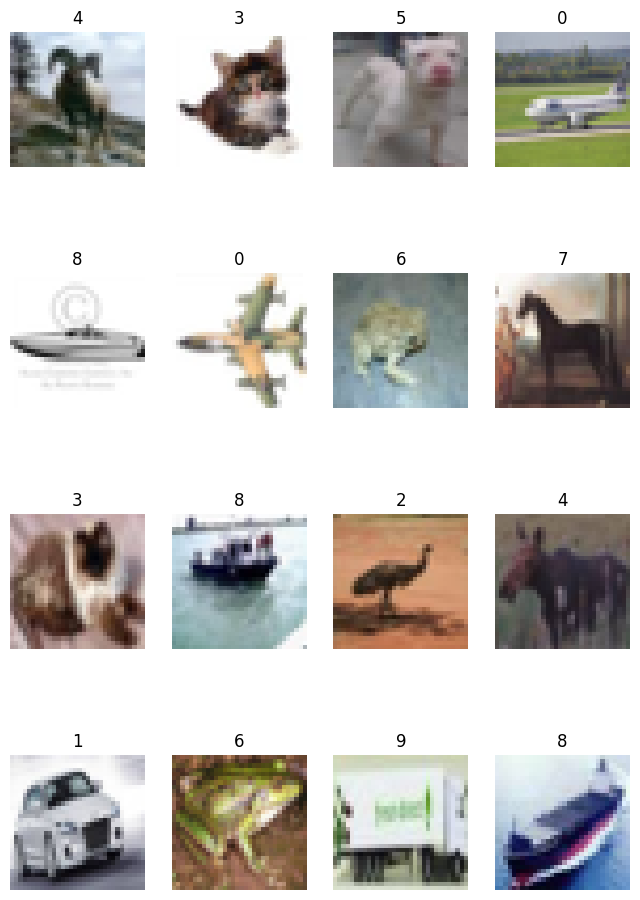

In [8]:
# Visualizing the Dataset
figure = plt.figure(figsize=(8,12))
cols, rows = 4,4
for i in range(1,cols*rows+1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img.permute(1,2,0))
plt.show()

In [9]:
num_channels=[32,64,128,256,256]

In [10]:
class VGG(nn.Module):
    def __init__(self, num_channels, output_dim):
        super().__init__()
        self.feature1 = nn.Sequential(
            nn.Conv2d(3, num_channels[0], kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_channels[0]),
            nn.Conv2d(num_channels[0], num_channels[0], kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_channels[0]),
            nn.MaxPool2d(2),
            nn.Conv2d(num_channels[0], num_channels[1], kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_channels[1]),
            nn.Conv2d(num_channels[1], num_channels[1], kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(num_channels[1])
        )
        self.feature2 = self.vgg_layers(num_channels[1], num_channels[2])
        self.feature3 = self.vgg_layers(num_channels[2], num_channels[3])
        self.feature4 = self.vgg_layers(num_channels[3], num_channels[4])
        self.feature5 = nn.MaxPool2d(2)
        self.classifier = nn.Sequential(
            nn.Linear(num_channels[4]*2*2, 1024, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, 1024, bias=False),
            nn.ReLU(inplace=True),
            nn.Dropout(0.7),
            nn.Linear(1024, output_dim)
        )

    def vgg_layers(self, input_channels, output_channels):
        layers=nn.Sequential(
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(output_channels),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(output_channels),
            nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(output_channels)
        )
        return layers

    def forward(self, x):
        x=self.feature1(x)
        x=self.feature2(x)
        x=self.feature3(x)
        x=self.feature4(x)
        x=self.feature5(x)
        x=x.view(x.shape[0],-1)

        return x

In [11]:
model = VGG(num_channels, 10)
print(model)

VGG(
  (feature1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (feature2): Sequential(
    (0): MaxPool2d(kernel_size=2, str

In [12]:
# Define optimizer and loss functions
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

In [13]:
summary(model, input_size=(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             864
              ReLU-2           [-1, 32, 64, 64]               0
       BatchNorm2d-3           [-1, 32, 64, 64]              64
            Conv2d-4           [-1, 32, 64, 64]           9,216
              ReLU-5           [-1, 32, 64, 64]               0
       BatchNorm2d-6           [-1, 32, 64, 64]              64
         MaxPool2d-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          18,432
              ReLU-9           [-1, 64, 32, 32]               0
      BatchNorm2d-10           [-1, 64, 32, 32]             128
           Conv2d-11           [-1, 64, 32, 32]          36,864
             ReLU-12           [-1, 64, 32, 32]               0
      BatchNorm2d-13           [-1, 64, 32, 32]             128
        MaxPool2d-14           [-1, 64,

In [14]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch, early_stopping_num):
    since = time.time()
    best_val_loss = float('inf')
    tr_losses=[]
    tr_accs=[]
    val_losses=[]
    val_accs=[]
    i=0

    for epoch in range(num_epoch):
        if i==early_stopping_num:
            break
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else :
                model.eval()

            epoch_loss=0.0
            epoch_corrects = 0

            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # _ = values, preds = indices
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    # loss.item() makes a tensor of loss as a scalar
                    # size of the inputs of the 0-dim(32?)
                    epoch_loss +=loss.item() * inputs.size(0)
                    epoch_corrects +=torch.sum(preds == labels.data)

            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            if phase=='train':
                tr_losses.append(epoch_loss)
                tr_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                if best_val_loss>epoch_loss:
                    best_val_loss = epoch_loss
                    i=0
                else :
                    i+=1


            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))
    return tr_losses, tr_accs, val_losses, val_accs

In [15]:
EPOCHS=100
tr_losses, tr_accs, val_losses, val_accs = train_model(model, dataloader_dict, criterion, optimizer, EPOCHS, 10)

Epoch 1/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 2.0693 Acc:0.5315


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.4722 Acc:0.6373
Epoch 2/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 1.0999 Acc:0.7006


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 1.0002 Acc:0.7107
Epoch 3/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.7984 Acc:0.7613


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7792 Acc:0.7596
Epoch 4/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.6233 Acc:0.8053


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7187 Acc:0.7789
Epoch 5/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.4996 Acc:0.8406


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7191 Acc:0.7795
Epoch 6/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.4083 Acc:0.8678


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6409 Acc:0.7965
Epoch 7/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.3380 Acc:0.8908


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6985 Acc:0.7925
Epoch 8/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.2812 Acc:0.9084


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6934 Acc:0.7966
Epoch 9/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.2311 Acc:0.9261


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6745 Acc:0.8077
Epoch 10/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1842 Acc:0.9394


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7022 Acc:0.8056
Epoch 11/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1621 Acc:0.9479


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.6970 Acc:0.8163
Epoch 12/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1369 Acc:0.9559


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7989 Acc:0.7948
Epoch 13/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1296 Acc:0.9581


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7310 Acc:0.8107
Epoch 14/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1064 Acc:0.9655


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.8054 Acc:0.8042
Epoch 15/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.1033 Acc:0.9665


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.7675 Acc:0.8054
Epoch 16/100
------------------------------


  0%|          | 0/313 [00:00<?, ?it/s]

train Loss: 0.0912 Acc:0.9703


  0%|          | 0/79 [00:00<?, ?it/s]

val Loss: 0.8226 Acc:0.8057
Training complete in 4m 40s


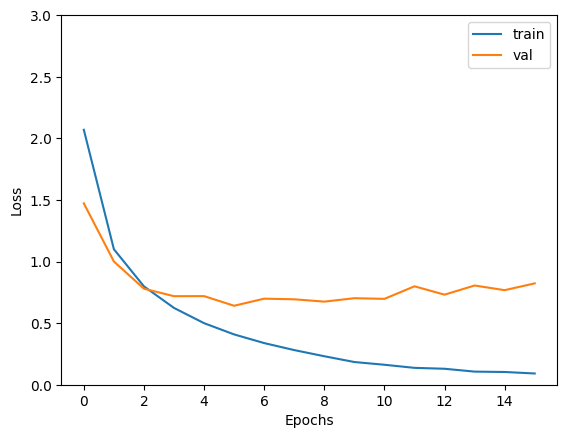

In [16]:
plt.plot(tr_losses)
plt.plot(val_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim([0,3])
plt.legend(['train', 'val'])
plt.show()

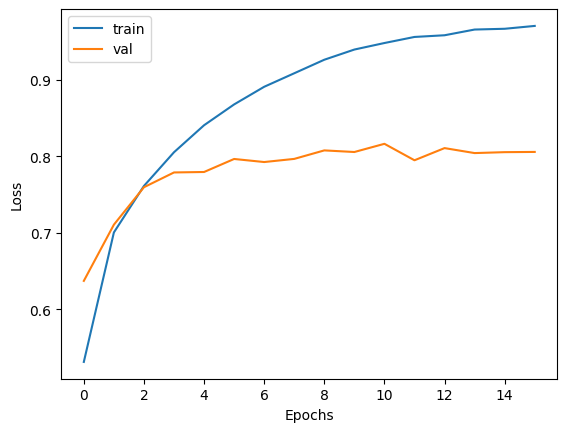

In [17]:
plt.plot(tr_accs)
plt.plot(val_accs)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'val'])
plt.show()

In [18]:
def test_model(model, test_iterator):
    since = time.time()
    model.eval()
    corrects = 0
    for inputs, labels in tqdm(test_iterator):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        # _ = values, preds = indices
        _, preds = torch.max(outputs, 1)
        corrects +=torch.sum(preds == labels.data)
    acc = corrects.double() / len(test_iterator.dataset)
    acc = acc.item()
    print('Accuracy of the test is {}%'.format(acc*100))
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed%60))

In [19]:
test_model(model, test_iter)

  0%|          | 0/79 [00:00<?, ?it/s]

Accuracy of the test is 80.26%
Test complete in 0m 3s
